In [1]:
import pretty_midi

In [2]:
midi = pretty_midi.PrettyMIDI('sample.mid')

In [3]:
piano_roll = midi.get_piano_roll()

In [4]:
piano_roll.shape

(128, 25460)

<Axes: >

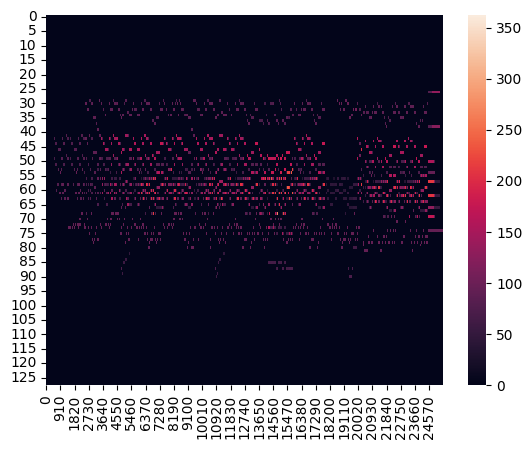

In [5]:
import seaborn as sns

sns.heatmap(piano_roll)

In [6]:
print(midi.instruments)
print(midi.key_signature_changes)
print(midi.time_signature_changes)
print(midi.lyrics)
print(midi.text_events)

[Instrument(program=5, is_drum=False, name="nameless"), Instrument(program=73, is_drum=False, name="nameless"), Instrument(program=25, is_drum=True, name="nameless"), Instrument(program=33, is_drum=False, name="nameless"), Instrument(program=25, is_drum=False, name="nameless"), Instrument(program=78, is_drum=False, name="nameless"), Instrument(program=89, is_drum=False, name="nameless")]
[KeySignature(key_number=0, time=0.0)]
[TimeSignature(numerator=4, denominator=4, time=0.0)]
[]
[]


In [7]:
midi.key_signature_changes

[KeySignature(key_number=0, time=0.0)]

In [8]:
midi.time_signature_changes

[TimeSignature(numerator=4, denominator=4, time=0.0)]

In [9]:
midi.get_downbeats()

array([  0.        ,   2.40295762,   4.92926963,   7.45558163,
         9.98189362,  12.50820562,  15.03451762,  17.56082962,
        20.08714163,  22.61345363,  25.13976563,  27.66607763,
        30.19238963,  32.71870163,  35.24501363,  37.77132562,
        40.29763762,  42.82394962,  45.35026162,  47.87657362,
        50.40288562,  52.92919762,  55.45550962,  57.98182162,
        60.50813362,  63.03444562,  65.56075762,  68.08706962,
        70.61338162,  73.13969362,  75.66600562,  78.19231763,
        80.71862963,  83.24494163,  85.77125363,  88.29756563,
        90.82387763,  93.35018963,  95.87650163,  98.40281363,
       100.92912563, 103.45543763, 105.98174963, 108.50806163,
       111.03437363, 113.56068563, 116.08699763, 118.61330963,
       121.13962163, 123.66593363, 126.19224563, 128.71855763,
       131.24486963, 133.77118163, 136.29749363, 138.82380563,
       141.35011763, 143.87642963, 146.40274163, 148.92905363,
       151.45536563, 153.98167762, 156.50798962, 159.03

<Axes: >

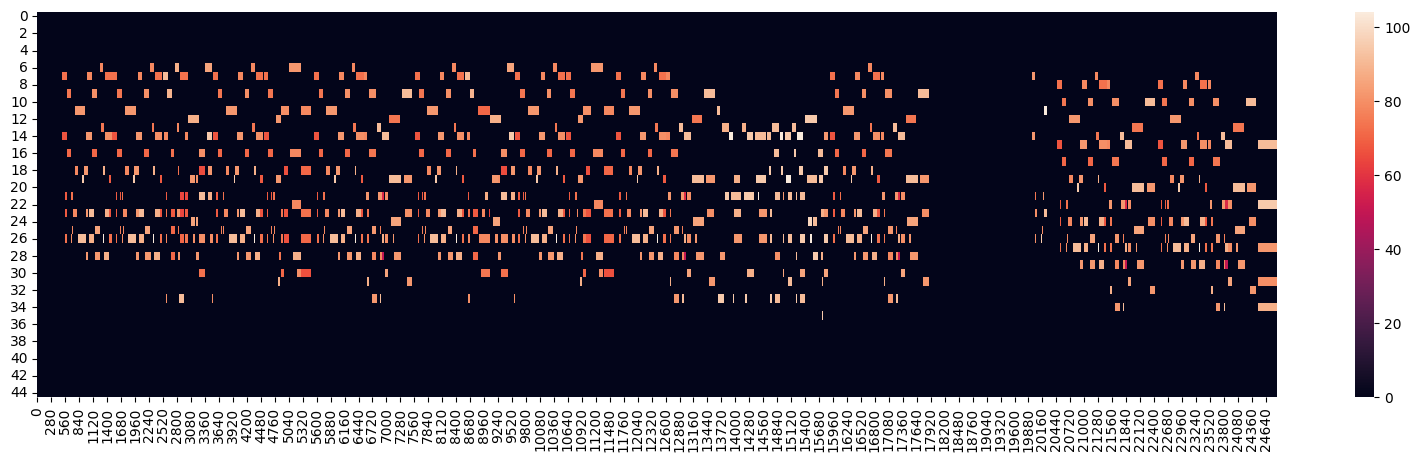

In [8]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20,5

sns.heatmap(midi.instruments[0].get_piano_roll()[35:80, :])

In [9]:
len(midi.instruments[1].notes)

521

In [10]:
print(midi.instruments[1].pitch_bends)
print(midi.instruments[1].control_changes)

[]
[ControlChange(number=0, value=0, time=0.109375), ControlChange(number=32, value=0, time=0.114583), ControlChange(number=7, value=70, time=0.125000), ControlChange(number=10, value=64, time=0.130208), ControlChange(number=91, value=120, time=0.135417), ControlChange(number=93, value=83, time=0.140625), ControlChange(number=101, value=0, time=0.145833), ControlChange(number=100, value=0, time=0.151042), ControlChange(number=6, value=2, time=0.156250), ControlChange(number=121, value=0, time=2.896378), ControlChange(number=11, value=127, time=3.159535)]


In [11]:
def get_bar(notes, bar_num):
    bar_start = midi.get_downbeats()[bar_num]
    bar_end = midi.get_downbeats()[bar_num+1]
    bar = []
    for note in notes:
        if note.start >= bar_start and note.end <= bar_end:
            bar.append(note)
    return bar

bar = get_bar(midi.instruments[0].notes, 2)

bar

[Note(start=5.560848, end=5.843742, pitch=56, velocity=68),
 Note(start=5.560848, end=5.843742, pitch=58, velocity=68),
 Note(start=5.560848, end=5.856900, pitch=61, velocity=73),
 Note(start=6.508215, end=6.593741, pitch=56, velocity=68),
 Note(start=6.508215, end=6.626635, pitch=60, velocity=76),
 Note(start=5.876637, end=6.771372, pitch=44, velocity=74),
 Note(start=5.876637, end=6.793741, pitch=51, velocity=71),
 Note(start=6.824004, end=6.992424, pitch=61, velocity=80),
 Note(start=6.824004, end=7.152950, pitch=56, velocity=73),
 Note(start=6.981898, end=7.179266, pitch=60, velocity=78)]

In [12]:
def get_bar_duration():
    return midi.get_downbeats()[1] - midi.get_downbeats()[0]

In [34]:
import networkx as nx 
import matplotlib.pyplot as plt
from typing import List


def visualize(nodes: List[pretty_midi.Note], edges): 
    G = nx.Graph()
    for node in nodes:
        G.add_node(node, pos=(-node.pitch, node.start))
    G.add_weighted_edges_from(edges)
    nx.draw_networkx(G)
    pos=nx.spring_layout(G)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show() 

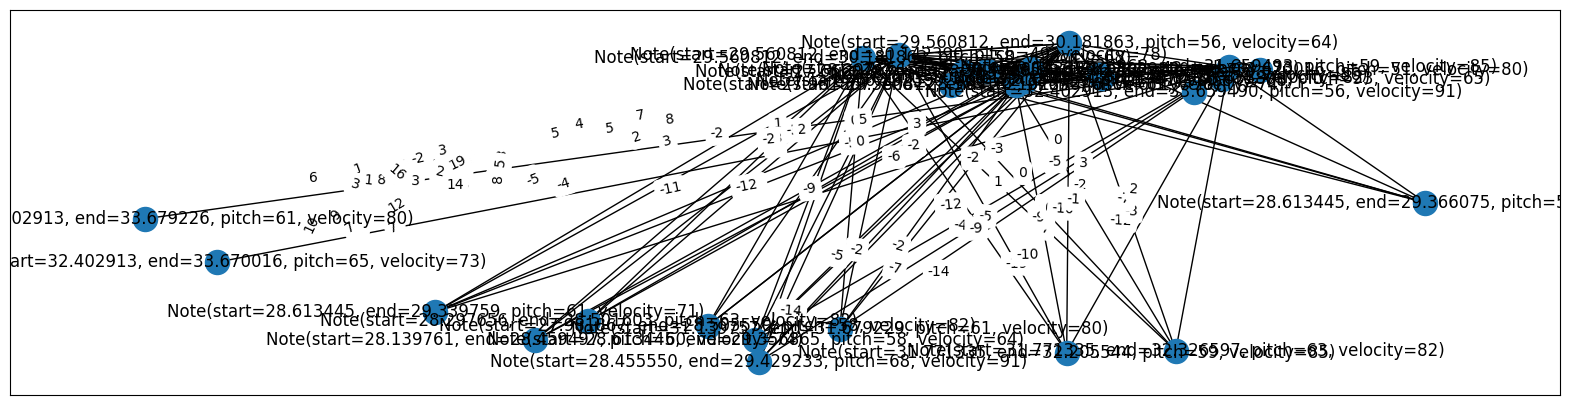

In [36]:
def get_notes_in_range(notes, start, end):
    notes_in_range = []
    for note in notes:
        if note.start >= start and note.end <= end:
            notes_in_range.append(note)
    return notes_in_range


edges = []

nodes = set()
for note in midi.instruments[0].notes[100:105]:
    neighbors = get_notes_in_range(midi.instruments[0].notes, note.start - get_bar_duration(), note.end + get_bar_duration())
    nodes.update(neighbors)
    for neighbor in neighbors:
        if neighbor != note:
            edges.append((note, neighbor, note.pitch - neighbor.pitch))

visualize(nodes, edges)


## Creating a token vocabulary

In [13]:
# TODO: Include all pitch/time info, or only pitch_class/time in bar info, or no pitch/time info?

def get_previous_downbeat(note):
    for i in range(len(midi.get_downbeats())):
        if note.start < midi.get_downbeats()[i]:
            return midi.get_downbeats()[i-1]
    return midi.get_downbeats()[-1]

def get_64th_note_duration():
    if midi.time_signature_changes[0].numerator % 3 == 0 and midi.time_signature_changes[0].numerator > 3:
        return (midi.get_beats()[1] - midi.get_beats()[0]) / 24        
    return (midi.get_beats()[2] - midi.get_beats()[1]) / 16

def get_note_token(note: pretty_midi.Note):
    position_in_bar = (note.start - get_previous_downbeat(note)) // get_64th_note_duration()
    return f"Pitch: {note.pitch%12}, Position in bar: {position_in_bar}"

# len(set([get_note_token(note) for note in midi.instruments[0].notes]))

<Axes: ylabel='Count'>

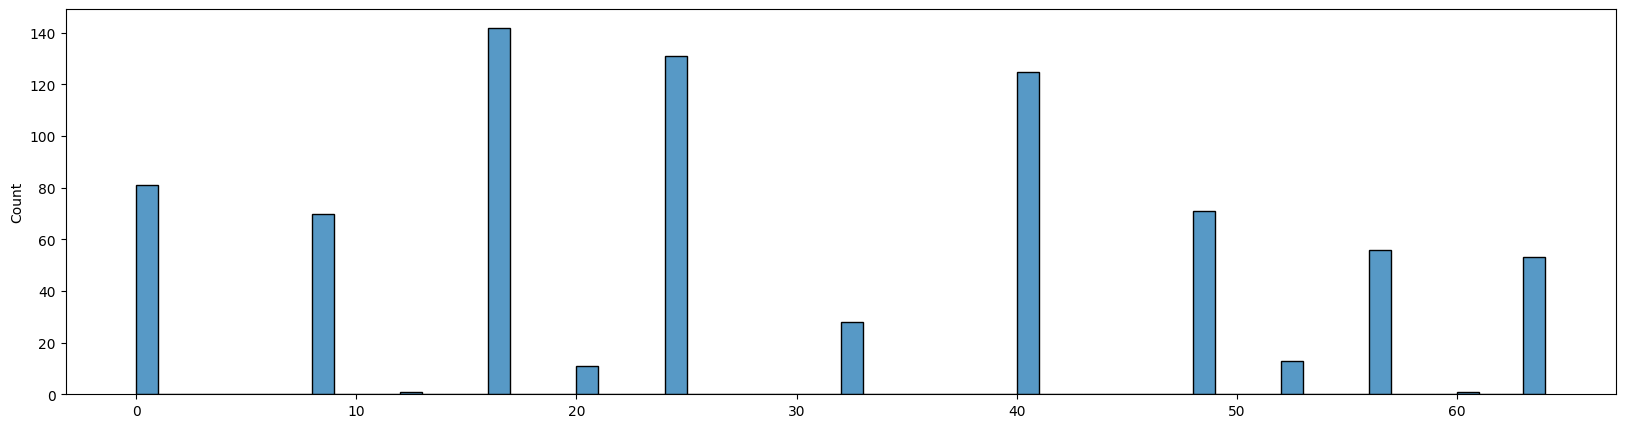

In [14]:
def get_note_position_in_bar(note: pretty_midi.Note):
    tick = get_64th_note_duration()
    time_within_bar = note.start - get_previous_downbeat(note)
    if time_within_bar % tick > tick / 2:
        return time_within_bar // tick + 1
    return time_within_bar // tick

sns.histplot([get_note_position_in_bar(note) for note in midi.instruments[0].notes], binwidth=1)

In [46]:
downbeats = midi.get_downbeats()
differences = [downbeats[i+1] - downbeats[i] for i in range(len(downbeats)-1)]
print(differences)

[2.402957625, 2.526312000000001, 2.526312000000001, 2.526311999999998, 2.5263119999999972, 2.5263119999999972, 2.5263120000000026, 2.5263120000000043, 2.5263120000000043, 2.5263120000000043, 2.5263120000000043, 2.5263120000000043, 2.5263119999999972, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.52631199999999, 2.5263120000000114, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000185, 2.5263120000000043, 2.52631199999

<Axes: ylabel='Count'>

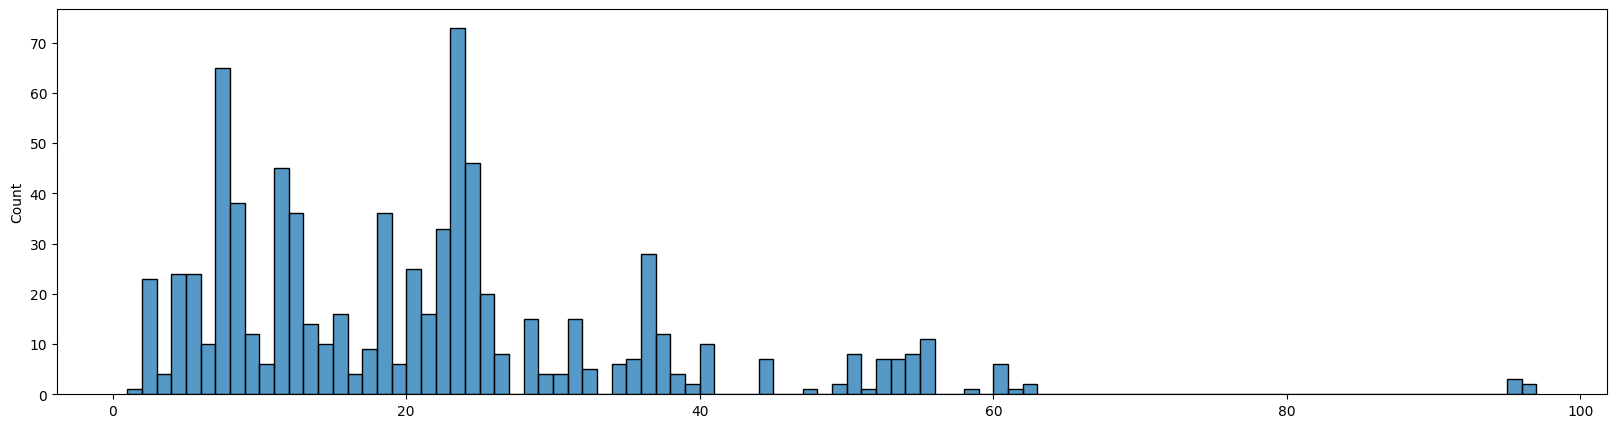

In [15]:
def get_note_duration(note: pretty_midi.Note):
    return (note.end - note.start) // get_64th_note_duration()
    return get_note_position_in_bar(pretty_midi.Note(start=note.end, end=note.end, pitch=note.pitch, velocity=note.velocity)) - get_note_position_in_bar(note)

sns.histplot([get_note_duration(note) for note in midi.instruments[0].notes], binwidth=1)

In [21]:
import numpy as np

class NoteToken:
    def __init__(self, note: pretty_midi.Note):
        self.pitch = note.pitch % 12
        self.start = get_note_position_in_bar(note)
        self.duration = get_note_duration(note)
        self.velocity = note.velocity

    # def __eq__(self, other):
    #     return self.pitch == other.pitch and self.position_in_bar == other.position_in_bar

    # def __hash__(self):
    #     return hash((self.pitch, self.position_in_bar))

    def __repr__(self):
        return f"Pitch: {self.pitch}, Position in bar: {self.start}, Duration: {self.duration}, Velocity: {self.velocity}"
    
    def to_vector(self):
        return np.array([
            self.pitch,
            self.start,
            self.duration,
            self.velocity
        ])

In [24]:
[NoteToken(x).to_vector() for x in midi.instruments[0].notes]

[array([ 8., 16.,  7., 68.]),
 array([10., 16.,  7., 68.]),
 array([ 1., 16.,  7., 73.]),
 array([ 6., 64., 24., 73.]),
 array([ 1., 64., 25., 67.]),
 array([ 8., 40.,  2., 68.]),
 array([ 0., 40.,  2., 76.]),
 array([ 8., 24., 22., 74.]),
 array([ 3., 24., 23., 71.]),
 array([ 1., 48.,  4., 80.]),
 array([ 8., 48.,  8., 73.]),
 array([ 0., 52.,  5., 78.]),
 array([10., 56., 20., 78.]),
 array([ 5., 64., 17., 78.]),
 array([ 6., 40.,  9., 95.]),
 array([10., 64., 55., 82.]),
 array([ 1., 16., 40., 91.]),
 array([ 5., 48., 20., 82.]),
 array([10., 56., 12., 82.]),
 array([ 3., 56., 12., 82.]),
 array([ 1., 56., 31., 82.]),
 array([ 6.,  0., 23., 78.]),
 array([10.,  8., 24., 91.]),
 array([ 1.,  8., 24., 88.]),
 array([ 8., 24., 23., 80.]),
 array([ 3., 24., 23., 71.]),
 array([ 0., 40., 23., 85.]),
 array([ 3., 40., 26., 82.]),
 array([ 5.,  0., 18., 78.]),
 array([ 0.,  8., 11., 74.]),
 array([  1.,  16.,   5., 104.]),
 array([ 5., 16.,  8., 88.]),
 array([10., 24., 23., 88.]),
 array

In [26]:
midi.instruments[0].program

5

In [27]:
from tokenizer import tokenize

tokenize(midi)

Tokenizing track number 6: 100%|██████████| 435/435 [00:00<00:00, 251207.80it/s]


[Pitch: 8, Position in bar: 80.0, Duration: 7.0, Velocity: 68, Instr: 5,
 Pitch: 10, Position in bar: 16.0, Duration: 7.0, Velocity: 68, Instr: 5,
 Pitch: 1, Position in bar: 16.0, Duration: 7.0, Velocity: 73, Instr: 5,
 Pitch: 6, Position in bar: 0.0, Duration: 24.0, Velocity: 73, Instr: 5,
 Pitch: 1, Position in bar: 0.0, Duration: 25.0, Velocity: 67, Instr: 5,
 Pitch: 8, Position in bar: 40.0, Duration: 2.0, Velocity: 68, Instr: 5,
 Pitch: 0, Position in bar: 40.0, Duration: 2.0, Velocity: 76, Instr: 5,
 Pitch: 8, Position in bar: 24.0, Duration: 22.0, Velocity: 74, Instr: 5,
 Pitch: 3, Position in bar: 24.0, Duration: 23.0, Velocity: 71, Instr: 5,
 Pitch: 1, Position in bar: 48.0, Duration: 4.0, Velocity: 80, Instr: 5,
 Pitch: 8, Position in bar: 48.0, Duration: 8.0, Velocity: 73, Instr: 5,
 Pitch: 0, Position in bar: 52.0, Duration: 5.0, Velocity: 78, Instr: 5,
 Pitch: 10, Position in bar: 56.0, Duration: 20.0, Velocity: 78, Instr: 5,
 Pitch: 5, Position in bar: 64.0, Duration: 17